In [13]:
import seaborn as sns
from astropy.io import fits
from multiprocessing import Pool
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from astropy.table import Table
plt.rcParams['axes.linewidth']= 3.
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
plt.rcParams['font.size'] = 35
plt.rcParams['figure.figsize'] = (16,16)

In [104]:
def make_percentiles(rhalo,re, rhalobins):
    
    med = []
    up =[]
    low=[]
    
    for i in range(len(rhalobins)-1):
        
        try:
            mask = np.ma.masked_inside(rhalo, rhalobins[i], rhalobins[i+1]).mask
            re_ = re[mask]
                
            if len(re_)>5:
                res = np.percentile(re_,[1,16,50,84,99])   
                mask = np.ma.masked_inside(re_, res[0], res[-1]).mask
                res = np.percentile(re_[mask],[16,50,84])   
                low.append(res[0])
                med.append(res[1])
                up.append(res[2])
            else:
                low.append(np.nan)
                med.append(np.nan)
                up.append(np.nan)

        except:
            low.append(np.nan)
            med.append(np.nan)
            up.append(np.nan)
        
    return np.array(low),np.array(med),np.array(up)    

In [74]:
def load_datasets(orig=True):

    if orig:
        TNG50 = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG50_Rot_blobsLike_orig_0.03_0.055.csv')[['objid','likelihood','galsky','skysig','LLR']]
        TNG = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG_Rot_blobsLike_orig_0.03_0.055.csv')
        Illustris = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/Illustris_Rot_blobsLike_orig_0.03_0.055.csv')[['objid','likelihood','LLR']]
        
        TNG50_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG50_ordered_Mgt9.5_skysub_orig.csv',sep=' ')[['objid','mag','sersic_n_r', 'sersic_rhalf_r']]
        TNG_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG_ordered_Mgt9.5_skysub_orig.csv',sep=' ')[['objid','mag']]
        Illustris_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_ill_ordered_Mgt9.5_skysub_orig.csv',sep=' ')#[['objid','mag']]
        
        TNG50 = TNG50.merge(TNG50_mag, on='objid')
        TNG = TNG.merge(TNG_mag, on='objid')
        Illustris = Illustris.merge(Illustris_mag, on='objid')      
        
    else:
        TNG50 = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG50_Rot_blobsLike_orig_0.03_0.055_magmatch.csv')
        TNG = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG_Rot_blobsLike_orig_0.03_0.055_magmatch.csv')
        Illustris = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/Illustris_Rot_blobsLike_orig_0.03_0.055_magmatch.csv')
        
        TNG_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG_ordered_Mgt9.5_skysub_magmatch.csv',sep=' ')[['objid','mag']]
        TNG50_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG50_ordered_Mgt9.5_skysub_magmatch.csv',sep=' ')[['objid','mag']]
        TNG50 = TNG50.merge(TNG50_mag, on='objid')
        TNG = TNG.merge(TNG_mag, on='objid')      
        
  
    SDSS = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/cleaned_df_bis_0.03_0.055_blobsLike_skysub.dat',sep=' ')[['objid','galcount','SFR','MhaloL','LCentSat']]
    SDSS_L = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/SDSS_Rot_blobsLike_0.03_0.055.csv')
    SDSS_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/cleaned_df_bis_0.03_0.055_blobsLike_skysub_onlymag.dat', sep= ' ')
    SDSS = SDSS.merge(SDSS_mag, on='galcount')
    SDSS = SDSS_L.merge(SDSS, on='galcount')
    
    # add physical properties to TNG
    df_f = pd.read_csv('/scratch/lzanisi/pixel-cnn/TNG_cutouts/snap_95_unfiltered_bis.csv')[['Unnamed: 0','ParentDM','SFR']]
    TNG = pd.merge(TNG, df_f, left_on='Illustris_ID_2_2', right_on='Unnamed: 0')
    centrals_jstar = pd.read_csv('/scratch/lzanisi/pixel-cnn/TNG_cutouts/TNG_jstar_s95_lzanisi.csv') #this contains only centrals
    TNG = pd.merge(TNG, centrals_jstar, left_on = 'Illustris_ID_2_2', right_on='Illustris_ID_2_1', how='outer' )
    TNG['LCentSat'] = TNG['sJ_star_1re'].apply(lambda x: 0 if x!=x else 1)
    TNG['SFR'] = TNG['SFR'].apply(lambda x: np.log10(x))
    
    #clean
    TNG = TNG.query('likelihood>3000 & sersic_n>0 & LLR>-50 & sersic_n<7  & LLR<500')
    TNG50 = TNG50.query('likelihood>3000 & sersic_n_r>0 & LLR>-50 & sersic_n_r<7  & LLR<500')

    Illustris = Illustris.query('likelihood>3000 & sersic_n>0 & LLR>-50  &  sersic_n<7 & LLR<500')
    SDSS = SDSS.query('likelihood>3000  & LLR>-50  & LLR<500 & GalSky_err>0 ')
    
    #rename
    SDSS['sky [nmaggie]'] = SDSS['GalSky'].apply(lambda x: 10**(-0.4*(x-22.5)  )*0.396**2)
    Illustris = Illustris.rename(columns={'galsky':'sky [nmaggie]'})
    TNG = TNG.rename(columns={'sky':'sky [nmaggie]','mag_x':'mag'}) 
    TNG50 = TNG50.rename(columns={'galsky':'sky [nmaggie]','mag_x':'mag'})

    
    TNG['$logR_e \ [arcsec]$'] = TNG['sersic_rhalf'].apply(np.log10)
    TNG['$n_{ser}$'] = TNG['sersic_n'].copy()
    TNG50['$logR_e \ [arcsec]$'] = TNG50['sersic_rhalf_r'].apply(np.log10)
    TNG50['$n_{ser}$'] = TNG50['sersic_n_r'].copy()
    Illustris['$logR_e \ [arcsec]$'] = Illustris['sersic_rhalf'].apply(np.log10)
    Illustris['$n_{ser}$'] = Illustris['sersic_n'].copy()
    SDSS['$logR_e \ [arcsec]$'] = SDSS['r_bulge'].apply(np.log10)
    SDSS['$n_{ser}$'] = SDSS['n_bulge'].copy()
    
    return SDSS, TNG50, TNG, Illustris

In [102]:
SDSS, TNG50, TNG, Illustris = load_datasets(orig=True)

/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

# Trends for photometric properties

## All galaxies and datasets

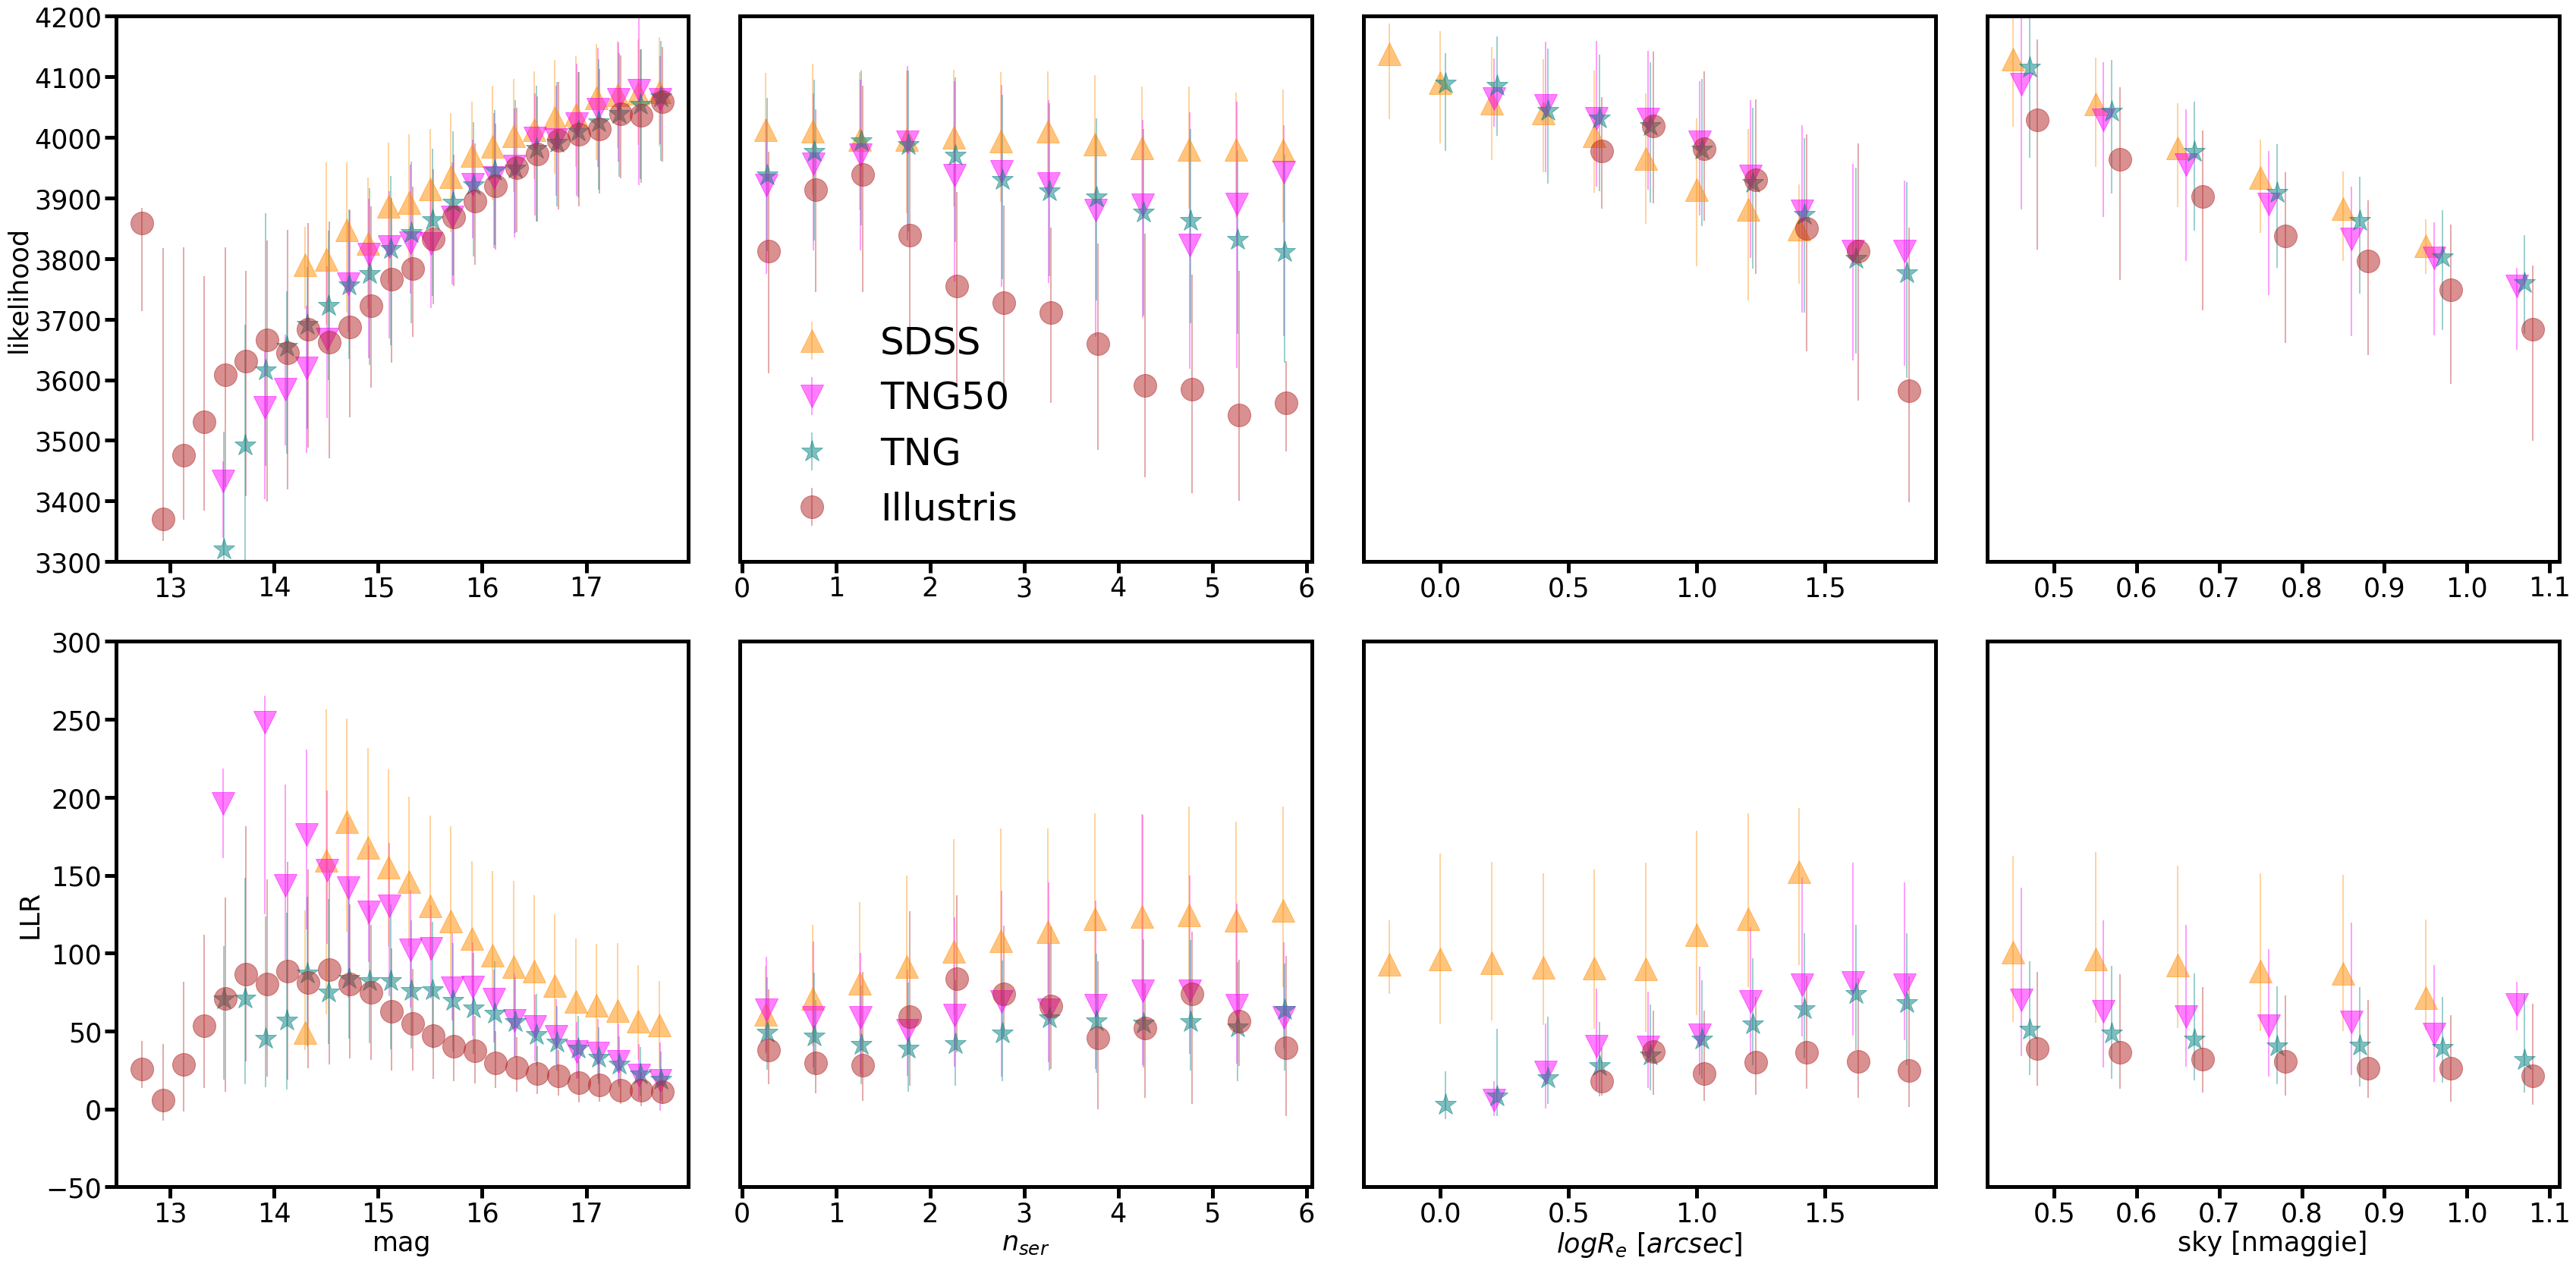

In [105]:
fig, ax = plt.subplots(2,4, figsize=(48,24))

kdims = ['mag','$n_{ser}$','$logR_e \ [arcsec]$','sky [nmaggie]']
bins_kdims = [np.arange(12,18,0.2),np.arange(0,6.5,0.5), np.arange(-0.5,2,0.2) , np.arange(0.4,1.2,0.1)]
vdims = ['likelihood','LLR']
for j,(this_ax,v) in enumerate(zip(ax,vdims)):  #this_ax is a row
    for a,(k, kbin) in zip(this_ax,zip(kdims,bins_kdims)):
        binwidth = kbin[1]-kbin[0]
        for dset, (col,mark,off, lab)  in zip([SDSS, TNG50,TNG, Illustris], zip(['darkorange','magenta','teal','firebrick'],['^','v','*','o'],[0,0.01,0.02,0.03], ['SDSS','TNG50','TNG','Illustris'])):
            
            if lab=='SDSS':
                low, med_norm, up = make_percentiles(dset[k],dset[v],kbin)
                med_norm = med_norm[~np.isnan(med_norm)]
            #print(k, lab, med_norm[0])
            temp = dset.copy()    
          #  temp[v] = temp[v].apply(lambda x: x/med_norm[0])
            low, med, up = make_percentiles(temp[k],temp[v],kbin)
            a.errorbar(kbin[1:]-binwidth/2+off, med,yerr=[med-low,up-med], color=col, fmt=mark, markersize=30, alpha=0.5, label=lab)
            if j==1:
                a.set_xlabel(k)
                
for i in range(4):
    ax[0][i].set_ylim(3300,4200)
    if i>0:
        ax[0][i].tick_params(axis='y',which='both',left=False, labelleft=False, labelbottom=False)
for i in range(4):
    ax[1][i].set_ylim(-50,300)
    if i>0:
        ax[1][i].tick_params(axis='y',which='both',left=False, labelleft=False)
    
ax[0][0].set_ylabel('likelihood')
ax[1][0].set_ylabel('LLR')
ax[0][1].legend(fontsize=50, frameon=False, loc='lower left')

plt.tight_layout()
#plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/LLR_L_trends/L_LLR_trends.pdf')
#plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/LLR_L_trends/L_LLR_trends.png')

## Only TNG100 and SDSS, centrals & satellites

Text(0.5, 0, 'LLR')

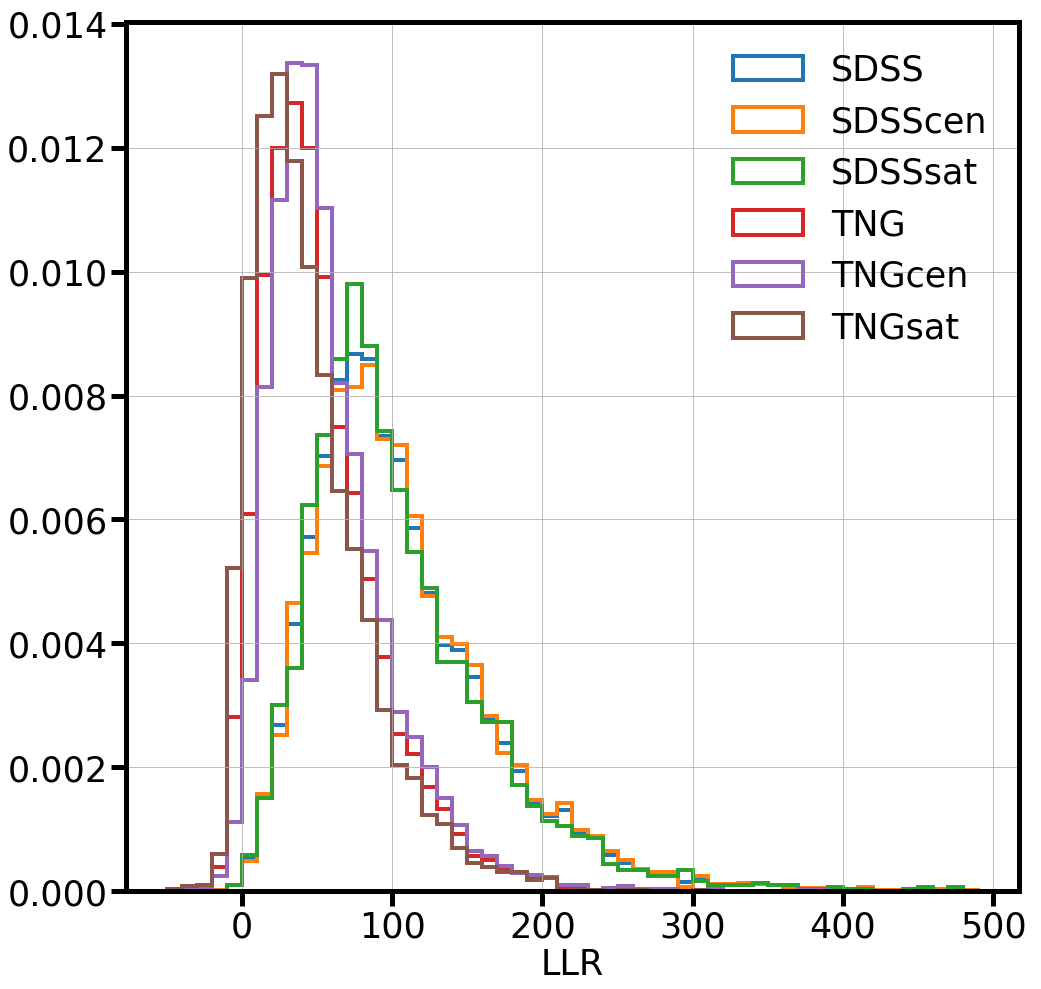

In [114]:
SDSS_cen = SDSS.query('LCentSat==1')
TNG_cen = TNG.query('LCentSat==1')
SDSS_sat = SDSS.query('LCentSat==2')
TNG_sat = TNG.query('LCentSat==0')

fig,ax=plt.subplots(1,1)
bins=np.arange(-50,500,10)
SDSS['LLR'].hist(bins=bins, histtype='step',density=True, label='SDSS', ax=ax, lw=4)
SDSS_cen['LLR'].hist(bins=bins, histtype='step',density=True, label='SDSScen', ax=ax, lw=4)
SDSS_sat['LLR'].hist(bins=bins, histtype='step',density=True, label='SDSSsat', ax=ax, lw=4)

TNG['LLR'].hist(bins=bins, histtype='step',density=True, label='TNG', ax=ax, lw=4)
TNG_cen['LLR'].hist(bins=bins, histtype='step',density=True, label='TNGcen', ax=ax, lw=4)
TNG_sat['LLR'].hist(bins=bins, histtype='step',density=True, label='TNGsat', ax=ax, lw=4)

plt.legend(frameon=False)
plt.xlabel('LLR')

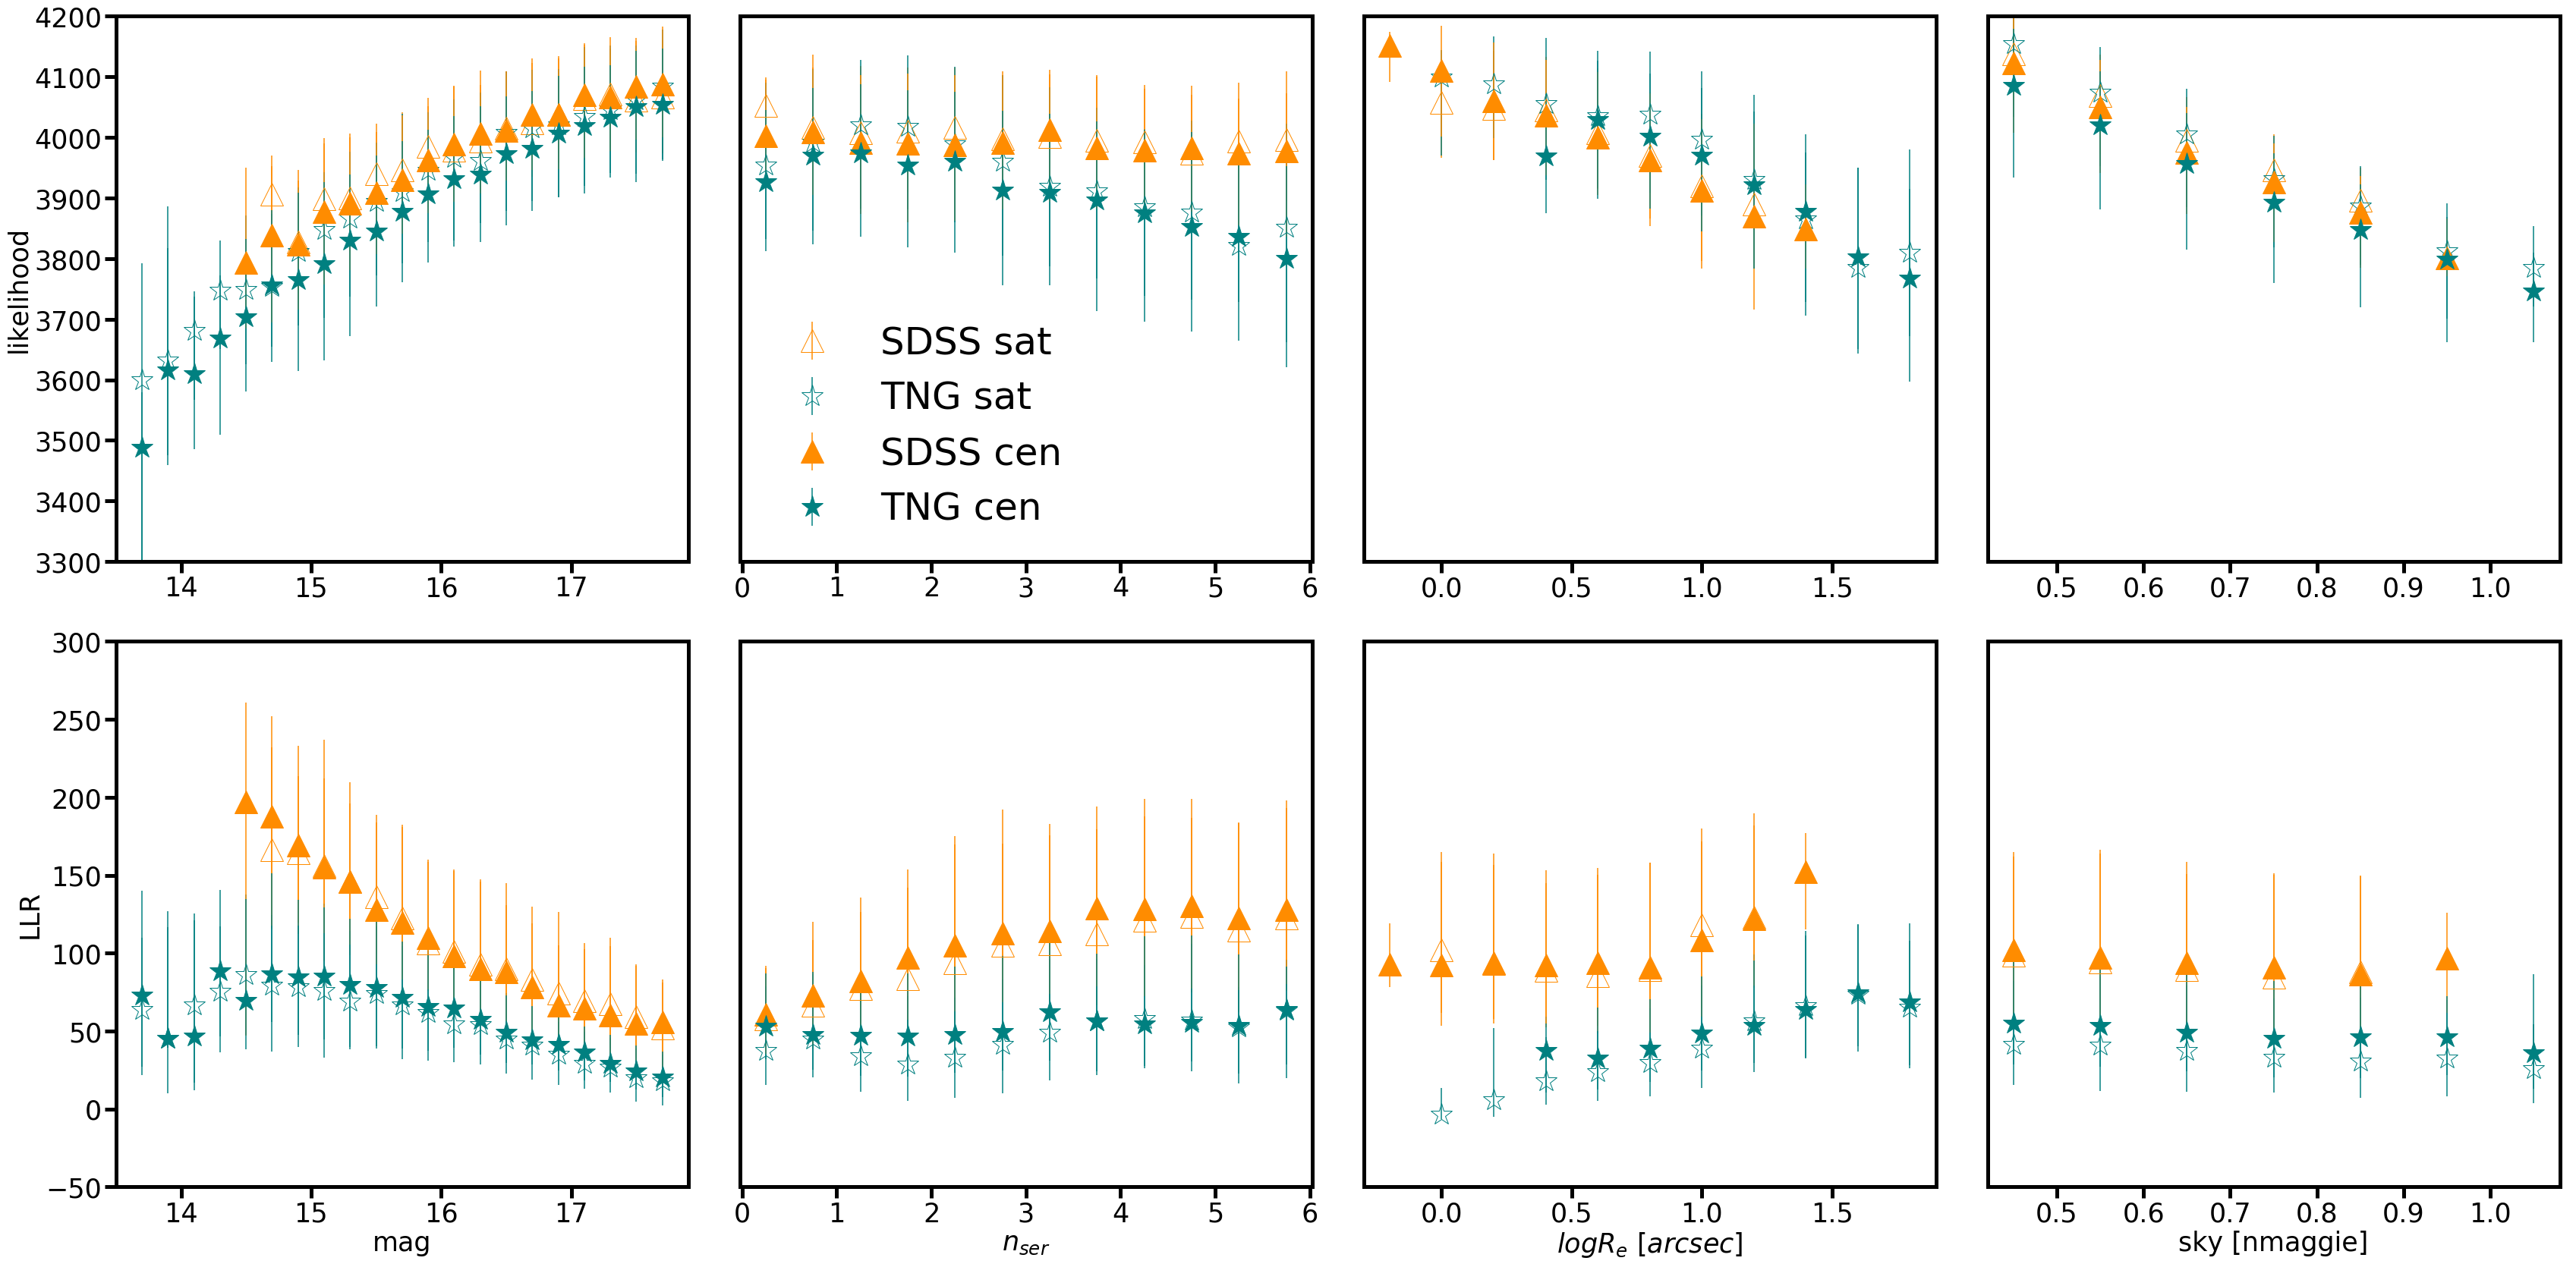

In [117]:
fig, ax = plt.subplots(2,4, figsize=(48,24))


kdims = ['mag','$n_{ser}$','$logR_e \ [arcsec]$','sky [nmaggie]']
bins_kdims = [np.arange(12,18,0.2),np.arange(0,6.5,0.5), np.arange(-0.5,2,0.2) , np.arange(0.4,1.2,0.1)]
vdims = ['likelihood','LLR']
                
for j,(this_ax,v) in enumerate(zip(ax,vdims)):  #this_ax is a row
    for a,(k, kbin) in zip(this_ax,zip(kdims,bins_kdims)):
        binwidth = kbin[1]-kbin[0]
        for dset, (col,mark,off, lab)  in zip([SDSS_sat, TNG_sat], zip(['darkorange','teal'],['^','*'],[0,0,0.03], ['SDSS sat','TNG sat'])):
        
            if lab=='SDSS':
                low, med_norm, up = make_percentiles(dset[k],dset[v],kbin)
                med_norm = med_norm[~np.isnan(med_norm)]
            #print(k, lab, med_norm[0])
            temp = dset.copy()    
          #  temp[v] = temp[v].apply(lambda x: x/med_norm[0])
            low, med, up = make_percentiles(temp[k],temp[v],kbin)
            a.errorbar(kbin[1:]-binwidth/2+off, med,yerr=[med-low,up-med], color=col, fmt=mark, fillstyle='none', markersize=30, alpha=1, label=lab)
            if j==1:
                a.set_xlabel(k)
                
for j,(this_ax,v) in enumerate(zip(ax,vdims)):  #this_ax is a row
    for a,(k, kbin) in zip(this_ax,zip(kdims,bins_kdims)):
        binwidth = kbin[1]-kbin[0]
        for dset, (col,mark,off, lab)  in zip([SDSS_cen, TNG_cen], zip(['darkorange','teal'],['^','*'],[0,0,0.03], ['SDSS cen ','TNG cen'])):
        
            if lab=='SDSS':
                low, med_norm, up = make_percentiles(dset[k],dset[v],kbin)
                med_norm = med_norm[~np.isnan(med_norm)]
            #print(k, lab, med_norm[0])
            temp = dset.copy()    
          #  temp[v] = temp[v].apply(lambda x: x/med_norm[0])
            low, med, up = make_percentiles(temp[k],temp[v],kbin)
            a.errorbar(kbin[1:]-binwidth/2+off, med,yerr=[med-low,up-med], color=col, fmt=mark, markersize=30, alpha=1, label=lab)
            if j==1:
                a.set_xlabel(k)

                
                
                
                
for i in range(4):
    ax[0][i].set_ylim(3300,4200)
    if i>0:
        ax[0][i].tick_params(axis='y',which='both',left=False, labelleft=False, labelbottom=False)
for i in range(4):
    ax[1][i].set_ylim(-50,300)
    if i>0:
        ax[1][i].tick_params(axis='y',which='both',left=False, labelleft=False)
    
ax[0][0].set_ylabel('likelihood')
ax[1][0].set_ylabel('LLR')
ax[0][1].legend(fontsize=50, frameon=False, loc='lower left')

plt.tight_layout()
#plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/LLR_L_trends/L_LLR_trends.pdf')
#plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/LLR_L_trends/L_LLR_trends.png')

# Trends for physical properties 

In [408]:
def make_percentiles2(rhalo,re, rhalobins,normbins):
    
    med = []
    up =[]
    low=[]
    
    for i in range(len(rhalobins)-1):
        
        try:
            mask = np.ma.masked_inside(rhalo, rhalobins[i], rhalobins[i+1]).mask
            re_ = re[mask]
                
            if len(re_)>10:
               # res = np.percentile(re_,[1,16,50,84,99])   
               # mask = np.ma.masked_inside(re_, res[0], res[-1]).mask
                #res = np.percentile(re_[mask],[16,50,84])   
                res = np.percentile(re_,[16,50,84])   
                low.append(res[0])
                med.append(res[1]-normbins[i])
                up.append(res[2])
            else:
                low.append(np.nan)
                med.append(np.nan)
                up.append(np.nan)

        except:
            low.append(np.nan)
            med.append(np.nan)
            up.append(np.nan)
        
    return np.array(low),np.array(med),np.array(up)    

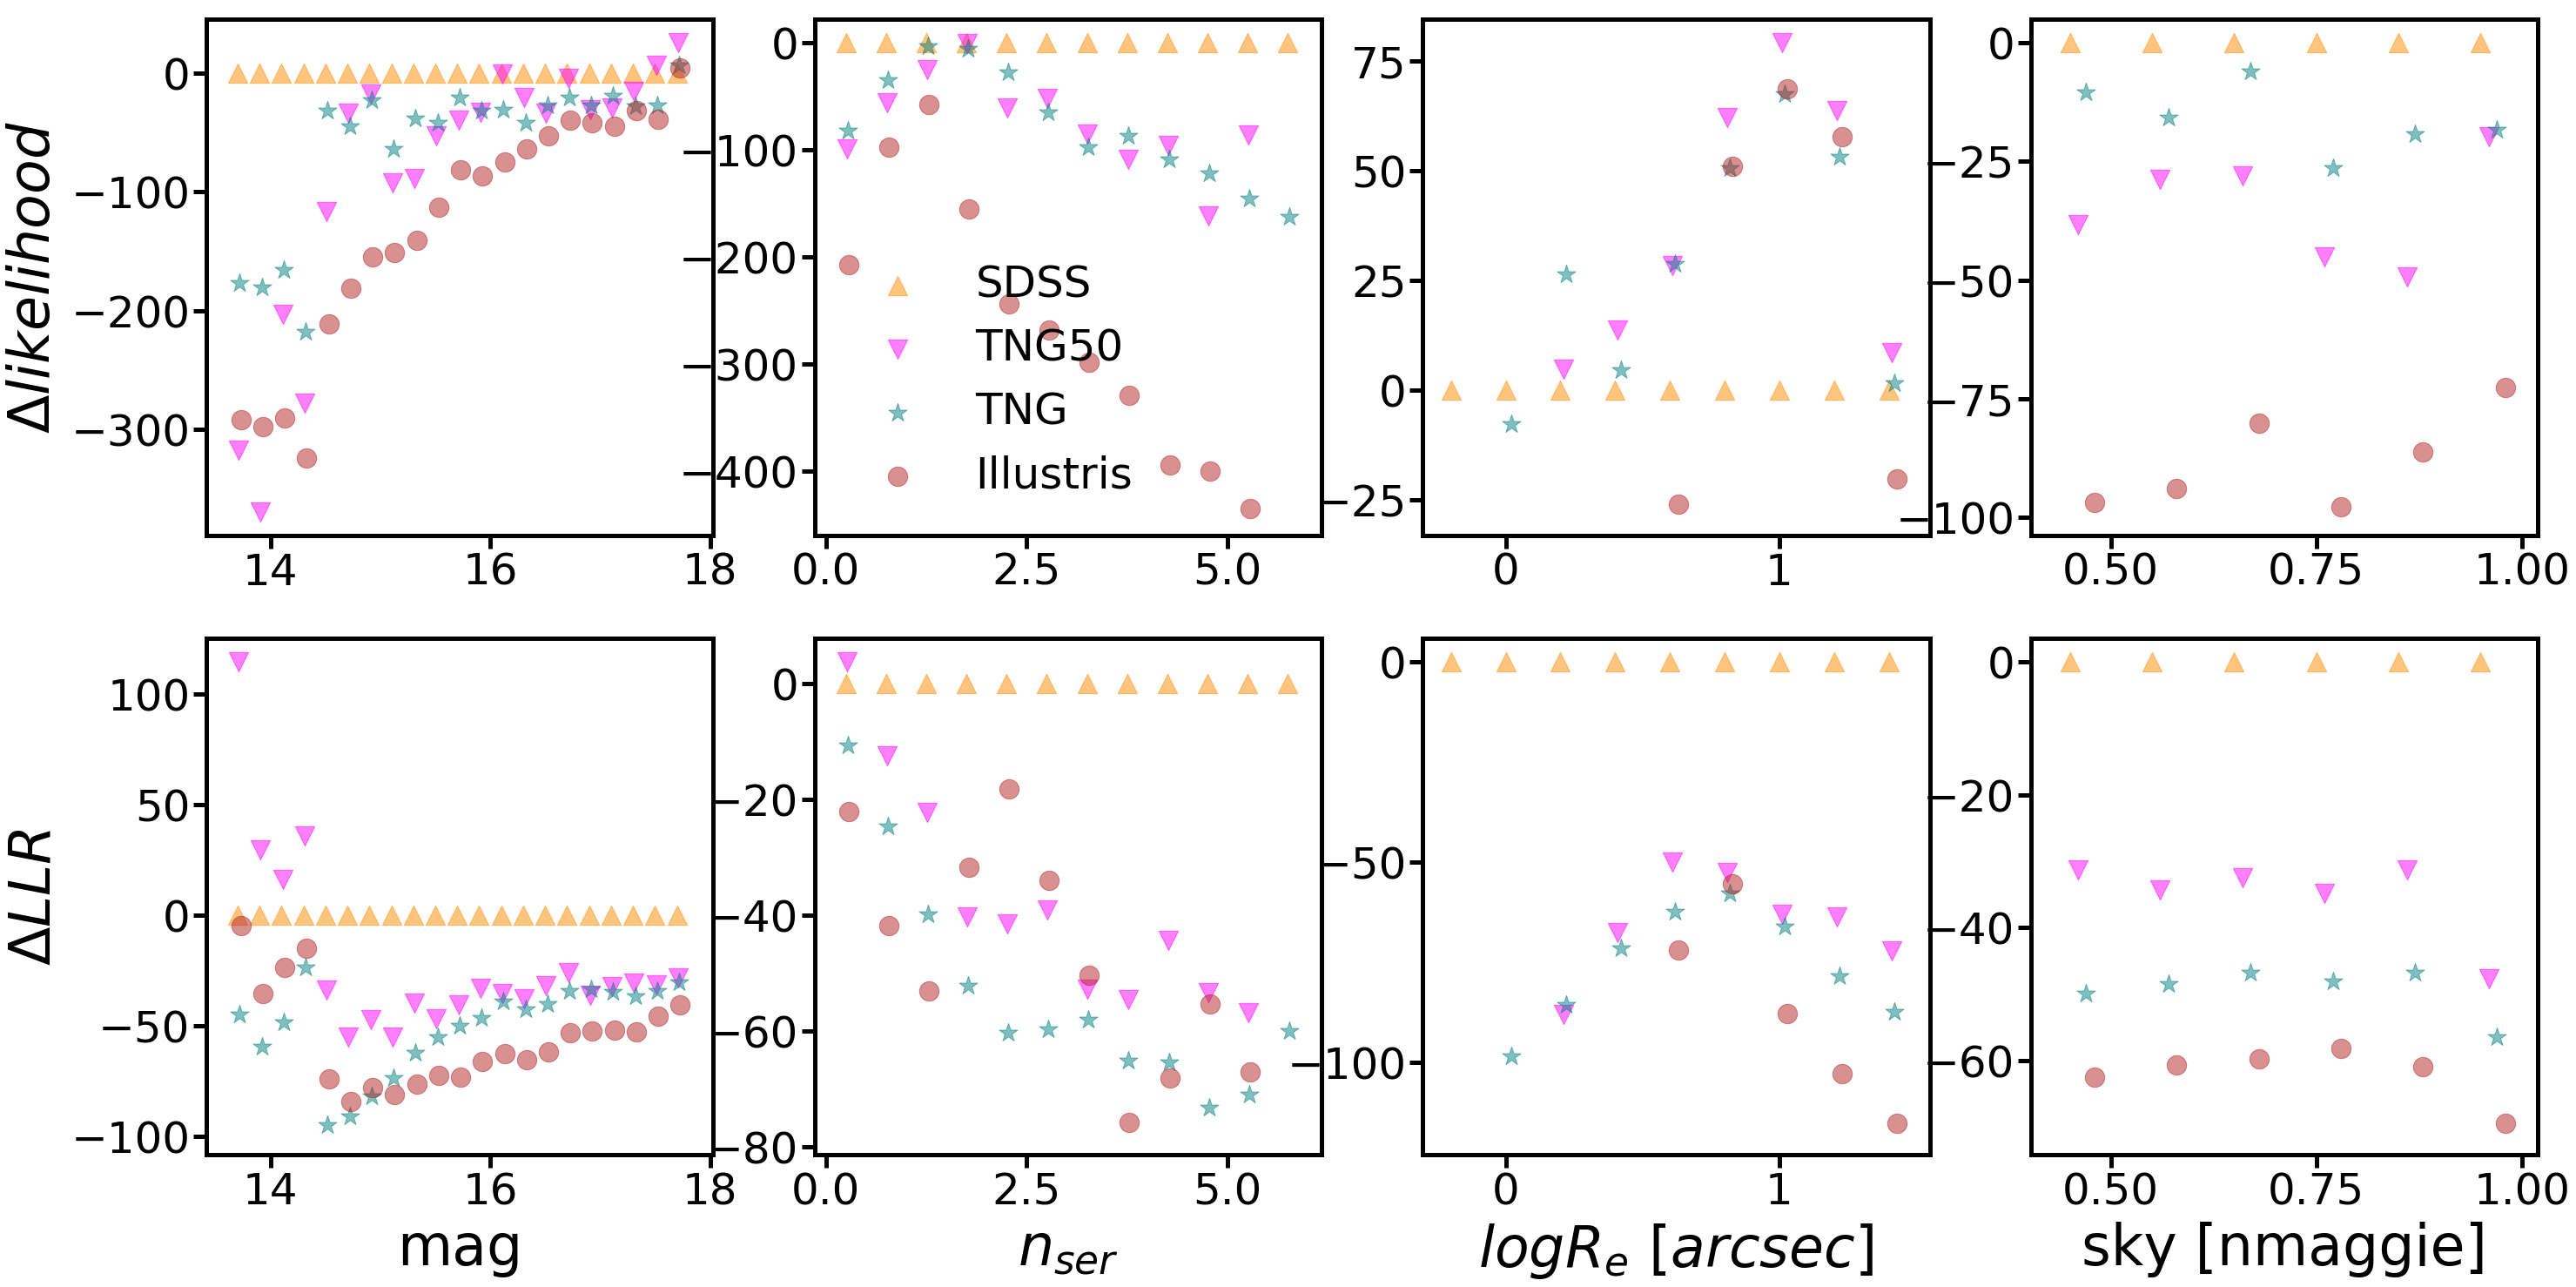

In [409]:
fig, ax = plt.subplots(2,4, figsize=(48,24))

kdims = ['mag','$n_{ser}$','$logR_e \ [arcsec]$','sky [nmaggie]']
bins_kdims = [np.arange(12,18,0.2),np.arange(0,6.5,0.5), np.arange(-0.5,2,0.2) , np.arange(0.4,1.2,0.1)]
vdims = ['likelihood','LLR']
for j,(this_ax,v) in enumerate(zip(ax,vdims)):  #this_ax is a row
    for a,(k, kbin) in zip(this_ax,zip(kdims,bins_kdims)):
        binwidth = kbin[1]-kbin[0]
        for dset, (col,mark,off, lab)  in zip([SDSS, TNG50,TNG, Illustris], zip(['darkorange','magenta','teal','firebrick'],['^','v','*','o'],[0,0.01,0.02,0.03], ['SDSS','TNG50','TNG','Illustris'])):
            
            if lab=='SDSS':
                low, med_norm, up = make_percentiles(dset[k],dset[v],kbin)
               # med_norm = med_norm[~np.isnan(med_norm)]
            #print(k, lab, med_norm[0])
            temp = dset.copy()    
            #temp[v] = temp[v].apply(lambda x: x/med_norm[0])
            low, med, up = make_percentiles2(temp[k],temp[v],kbin,med_norm)
            a.scatter(kbin[1:]-binwidth/2+off, med, color=col, marker=mark, s=500, alpha=0.5, label=lab)
            if j==1:
                a.set_xlabel(k)
                
#for i in range(4):
 #   ax[0][i].set_ylim(3300,4200)
#     if i>0:
#         ax[0][i].tick_params(axis='y',which='both',left=False, labelleft=False, labelbottom=False)
#for i in range(4):
#   #  ax[1][i].set_ylim(-50,300)
#     if i>0:
#         ax[1][i].tick_params(axis='y',which='both',left=False, labelleft=False)
    
ax[0][0].set_ylabel('$\Delta likelihood$')
ax[1][0].set_ylabel('$\Delta LLR$')
ax[0][1].legend(fontsize=50, frameon=False, loc='lower left')


# explore images 

In [320]:
import pickle as pkl
with open('/scratch/lzanisi/pixel-cnn/TNG50_cutouts/0.045_skysub_orig_Mgt9.5.pkl','rb') as f:
    obj = pkl.load(f)

In [338]:
data = np.array(obj['data'])

In [410]:
TNG50 = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG50_Rot_blobsLike_orig_0.03_0.055.csv')[['objid','likelihood','galsky','skysig','LLR']]
TNG50_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_TNG50_ordered_Mgt9.5_skysub_orig.csv',sep=' ')[['objid','mag','sersic_n_r', 'sersic_rhalf_r']]
TNG50 = TNG50_mag.merge(TNG50,on='objid')

In [430]:
ind =  TNG50.query('mag<14 & mag>13.6 & LLR>200 ').index.values
len(ind)

21

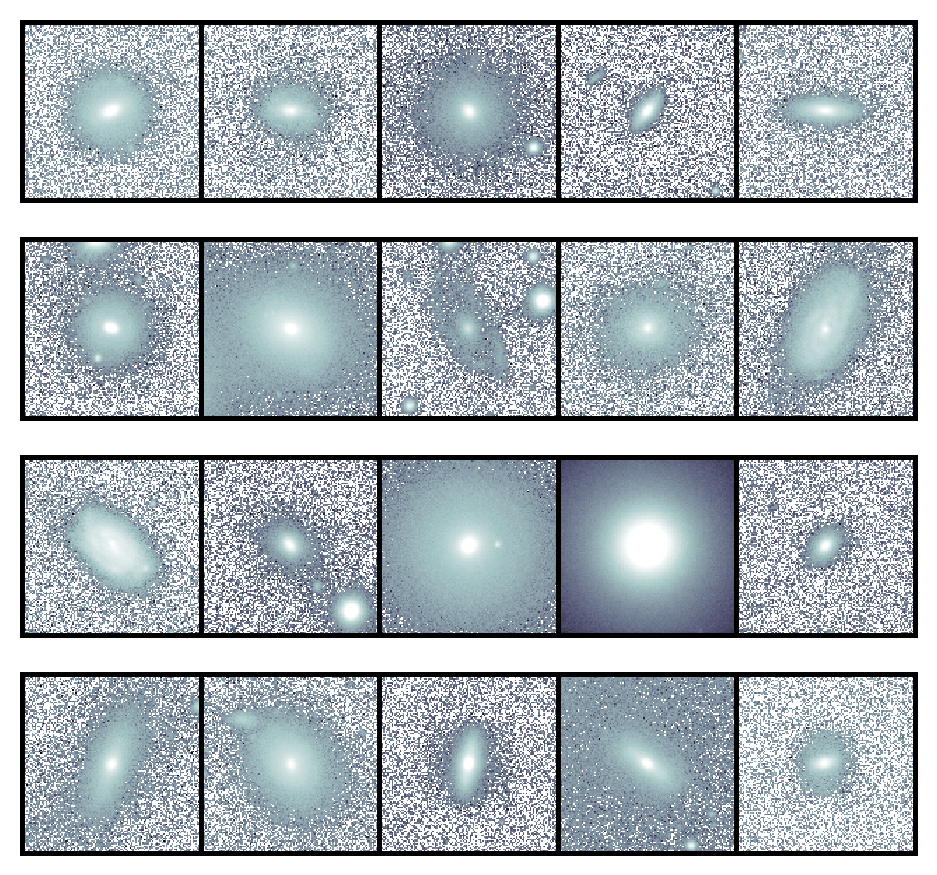

In [433]:
import matplotlib.colors as colors
prova = data[ind]
ii = np.random.choice(range(len(prova)), 20, replace=False )
fig, ax=plt.subplots(4,5,sharey=True,sharex=True)
for a,i in zip(ax.ravel(),ii):
    
    a.imshow(data[i], cmap='bone', norm=colors.LogNorm())
    a.tick_params(axis='both',which='both',bottom=False, left=False, labelleft=False, labelbottom=False)
plt.subplots_adjust(hspace=0,wspace=0)

In [413]:
with open('/scratch/lzanisi/pixel-cnn/SDSS_cutouts/0.03_0.055_Mstar_gt9.5_asinh_test_blobsLike_skysub.pkl','rb') as f:
    obj = pkl.load(f)
    obsdata = np.array(obj['data'])
    objid = np.array(obj['objid'])

In [414]:
df = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/cleaned_df_bis_0.03_0.055_blobsLike_skysub.dat', sep=' ')[35000:]
SDSS_mag = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/cleaned_df_bis_0.03_0.055_blobsLike_skysub_onlymag.dat', sep= ' ')
df = df.merge(SDSS_mag, on='galcount')
SDSS = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/SDSS_Rot_blobsLike_0.03_0.055.csv')[['objid','likelihood','LLR']]
df = df.merge(SDSS, on='objid')

In [416]:
df.shape

(9196, 23)

In [417]:
ind = df.query('mag<14 & mag>13.6').index.values


9196

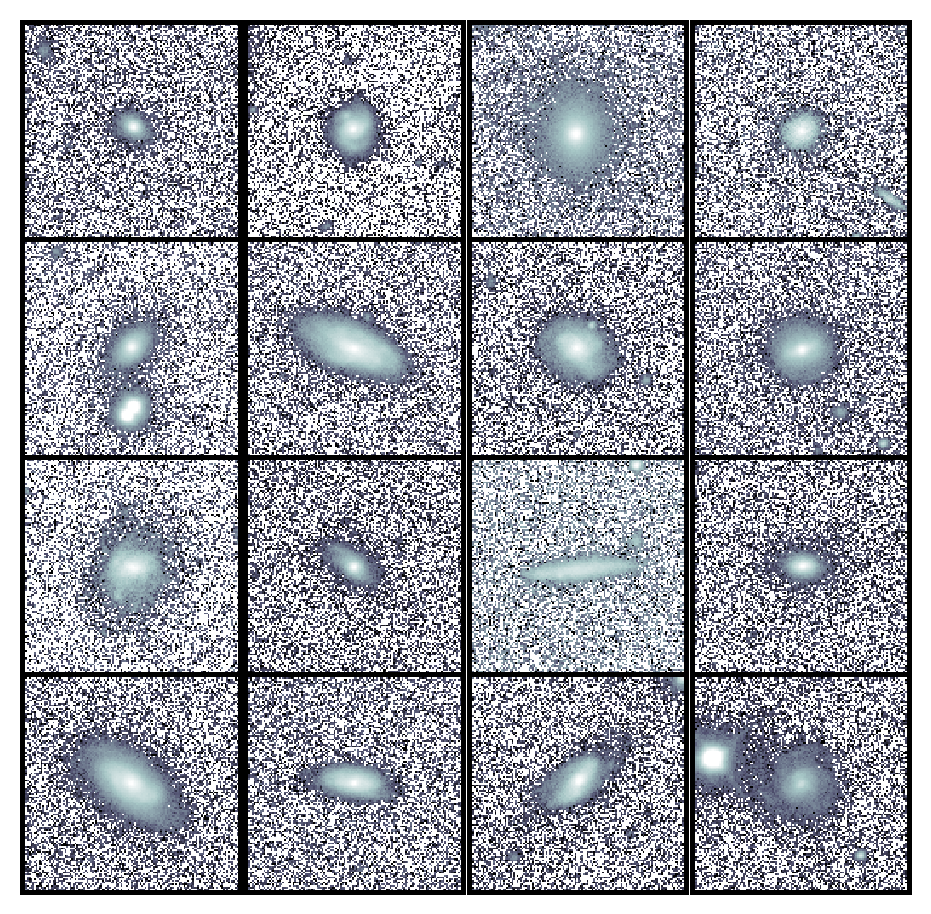

In [378]:
import matplotlib.colors as colors
prova = obsdata[ind]
ii = np.random.choice(range(len(prova)), 16, replace=False)
fig, ax=plt.subplots(4,4,sharey=True,sharex=True)
for a,i in zip(ax.ravel(),ii):
    
    a.imshow(obsdata[i], cmap='bone', norm=colors.LogNorm())
    a.tick_params(axis='both',which='both',bottom=False, left=False, labelleft=False, labelbottom=False)
plt.subplots_adjust(hspace=0,wspace=0)

In [418]:
df['galsky'] = df['GalSky'].apply(lambda x: 10**(-0.4*(x-22.5)  )*0.396**2)


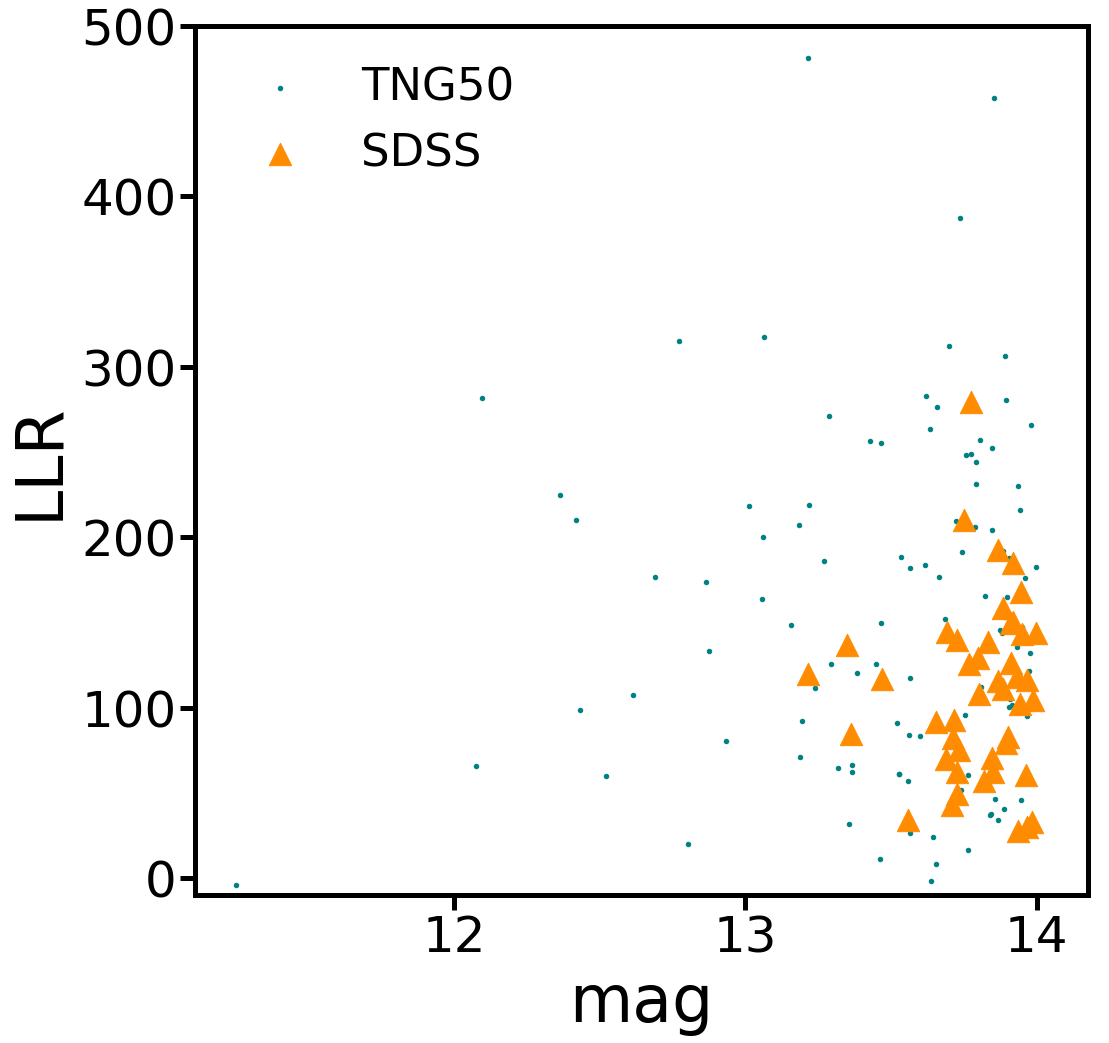

In [434]:
fig,ax = plt.subplots(1,1)
TNG50.query('mag<14').plot.scatter('mag','LLR', ax=ax, color='teal',label='TNG50')
df.query('mag<14').plot.scatter('mag','LLR', ax=ax, marker='^', s=500, color='darkorange',label='SDSS')
ax.set_ylim(-10,500)
plt.legend(frameon=False, fontsize=45)

/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'galsky [nmaggie]')

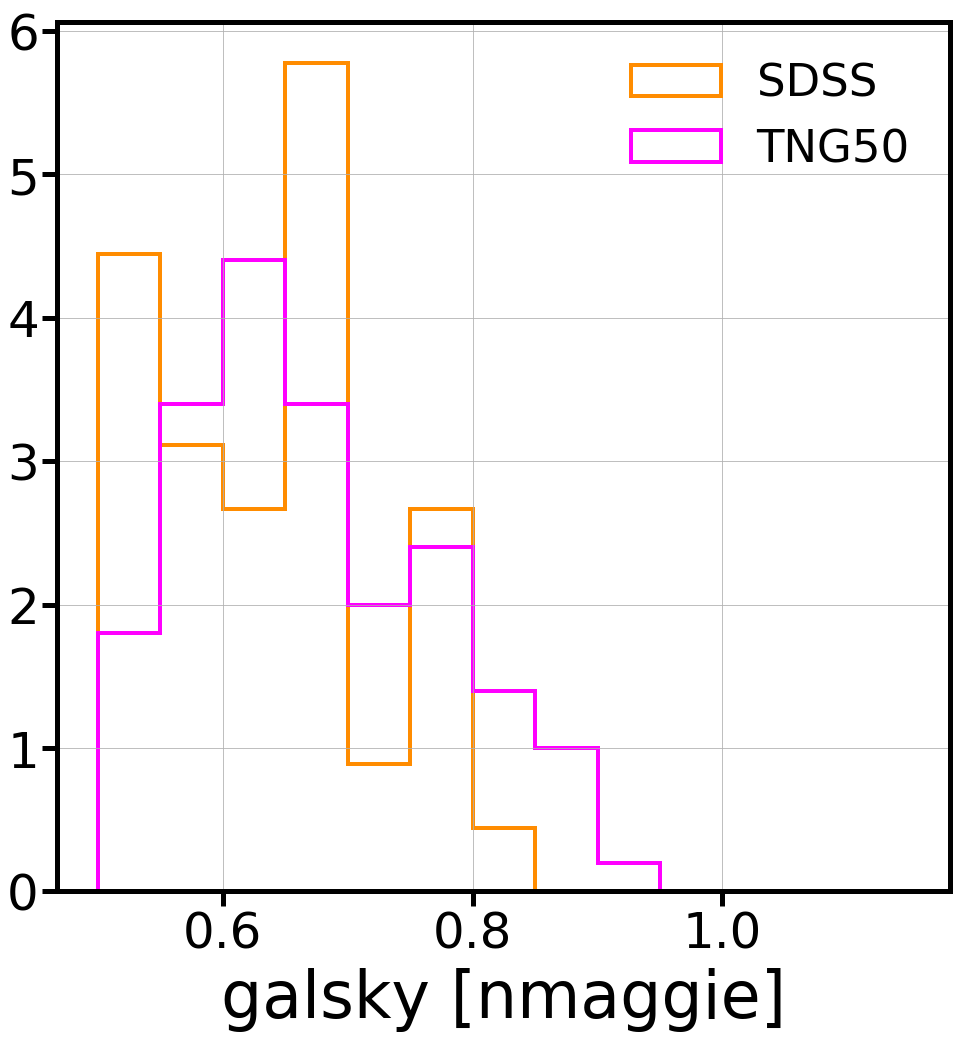

In [429]:
df.query('mag<14').galsky.hist(bins=np.arange(0.5,1.2,0.05), normed=True, histtype='step',lw=4, label='SDSS', color='darkorange')
TNG50.query('mag<14').galsky.hist(bins=np.arange(0.5,1.2,0.05), normed=True, histtype='step',lw=4, label='TNG50', color='magenta')

plt.legend(fontsize=45, frameon=False)
plt.xlabel('galsky [nmaggie]')

In [457]:
SDSS.columns

Index(['likelihood', 'objid', 'galcount', 'galsky', 'skysig', 'Unnamed: 0',
       'm_bulge', 'r_bulge', 'ba_bulge', 'n_bulge', 'GalSky', 'GalSky_err',
       'chi2nu', 'finalflag', 'z', 'MsMendSerExp', 'aa', 'airmass', 'kk',
       'GalSky_SDSS', 'skySig_r', 'likelihood_shuffled', 'objid_shuffled',
       'galsky_shuffled', 'skysig_shuffled', 'Unnamed: 0_shuffled',
       'm_bulge_shuffled', 'r_bulge_shuffled', 'ba_bulge_shuffled',
       'n_bulge_shuffled', 'GalSky_shuffled', 'GalSky_err_shuffled',
       'chi2nu_shuffled', 'finalflag_shuffled', 'z_shuffled',
       'MsMendSerExp_shuffled', 'aa_shuffled', 'airmass_shuffled',
       'kk_shuffled', 'GalSky_SDSS_shuffled', 'skySig_r_shuffled', 'LLR',
       'mag', 'sky [nmaggie]', '$logR_e \ [arcsec]$', '$n_{ser}$'],
      dtype='object')

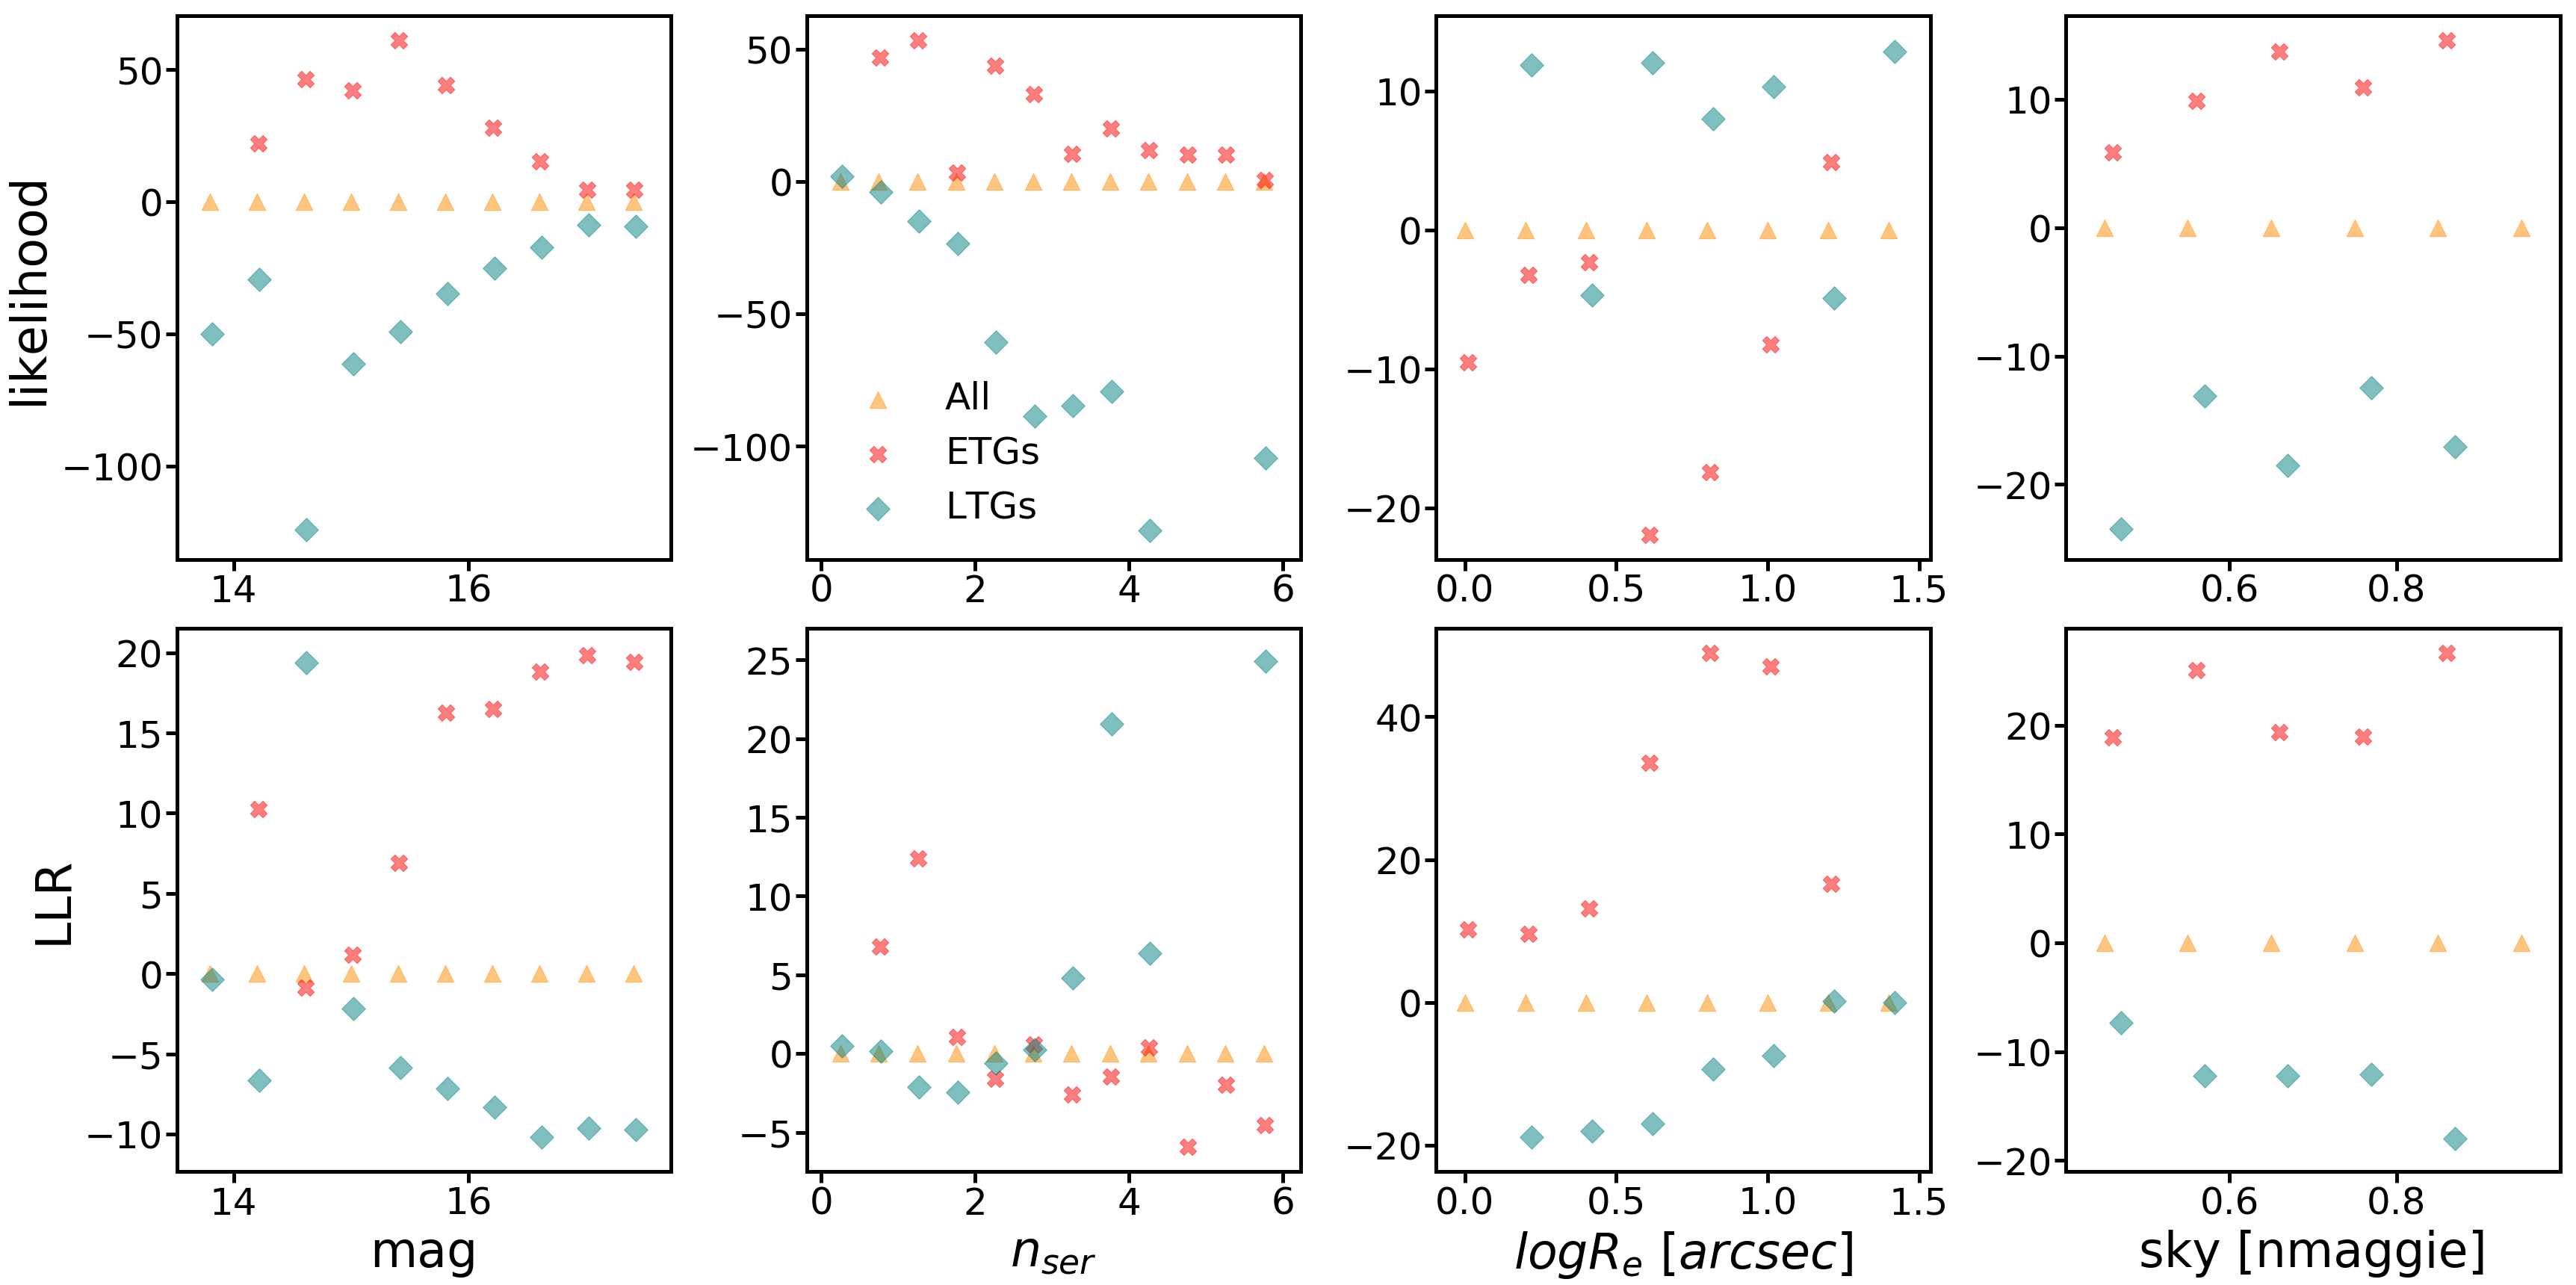

In [479]:
fig, ax = plt.subplots(2,4, figsize=(48,24))
ETGs = SDSS.query('TType<-1')
LTGs = SDSS.query('TType>3')

kdims = ['mag','$n_{ser}$','$logR_e \ [arcsec]$','sky [nmaggie]']
bins_kdims = [np.arange(12,18,0.4),np.arange(0,6.5,0.5), np.arange(-0.5,2,0.2) , np.arange(0.4,1.2,0.1)]
vdims = ['likelihood','LLR']
for j,(this_ax,v) in enumerate(zip(ax,vdims)):  #this_ax is a row
    for a,(k, kbin) in zip(this_ax,zip(kdims,bins_kdims)):
        binwidth = kbin[1]-kbin[0]
        for dset, (col,mark,off, lab)  in zip([SDSS,ETGs, LTGs], zip(['darkorange','red','teal'],['^','X','D'],[0,0.01,0.02], ['All','ETGs','LTGs'])):
            if lab=='All':
                low, med_norm, up = make_percentiles(dset[k],dset[v],kbin)
            temp = dset.copy()
            
           # med = med[~np.isnan(med)]
            #temp[v] = temp[v].apply(lambda x: x/med[0])
            low, med, up = make_percentiles2(temp[k],temp[v],kbin, med_norm)
            #a.errorbar(kbin[1:]-binwidth/2+off, med,yerr=[med-low,up-med], color=col, fmt=mark, markersize=30, alpha=0.5, label=lab)
            a.scatter(kbin[1:]-binwidth/2+off, med, color=col, marker=mark, s=500, alpha=0.5, label=lab)
            if j==1:
                a.set_xlabel(k)
                
# for i in range(4):
#     ax[0][i].set_ylim(3600,4200)
#     if i>0:
#         ax[0][i].tick_params(axis='y',which='both',left=False, labelleft=False, labelbottom=False)
# for i in range(4):
#     ax[1][i].set_ylim(-50,300)
#     if i>0:
#         ax[1][i].tick_params(axis='y',which='both',left=False, labelleft=False)
    
ax[0][0].set_ylabel('likelihood')
ax[1][0].set_ylabel('LLR')
ax[0][1].legend(fontsize=50, frameon=False, loc='lower left')

plt.tight_layout()
#plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/resu
plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/LLR_L_trends/L_LLR_trends_TType.png')

#  LLR distributions in bins of...

## mag

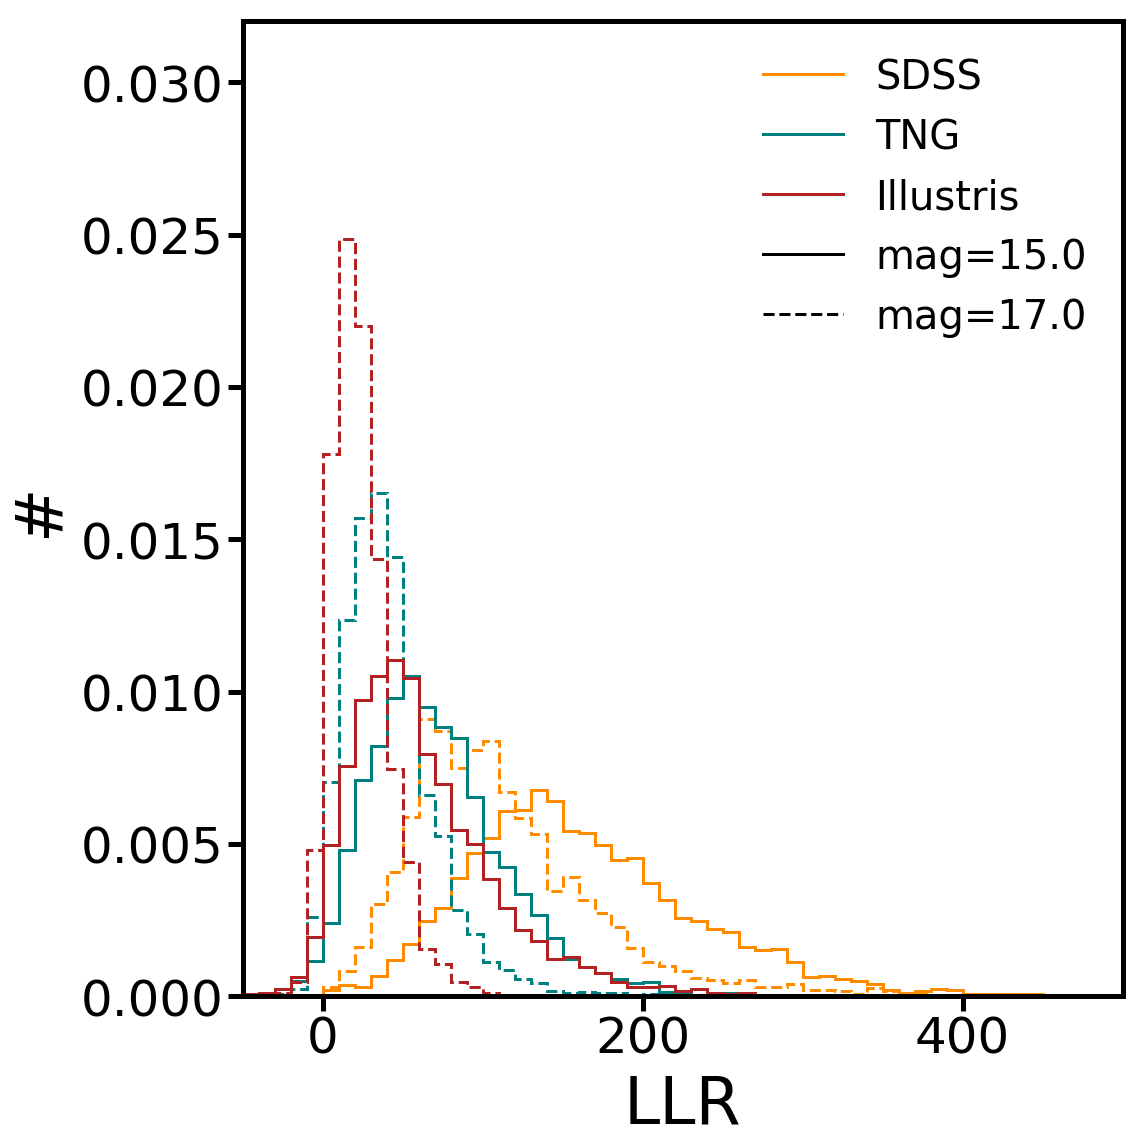

In [234]:
magbins = np.linspace(14,18,3)
linestyles = ['-','--','-.',':']
colors = ['darkorange','teal','firebrick']
labels = ['SDSS','TNG','Illustris']
dsets = [SDSS, TNG,Illustris]


for dset, (lab,col) in zip(dsets, zip(labels,colors)):
    for i, ls in zip(range(len(magbins)-1),linestyles):
        df = dset[(dset['mag']>magbins[i]) & (dset['mag']<magbins[i+1])]
        plt.hist(df['LLR'].values,histtype='step', density=True, color=col, linestyle=ls, lw=3, bins=np.arange(-50,500,10))
        
x = np.arange(100,100)+10000
plt.plot(x,x, color=colors[0], label='SDSS', lw=3)
plt.plot(x,x, color=colors[1], label='TNG', lw=3)
plt.plot(x,x, color=colors[2], label='Illustris', lw=3)

magwidth = magbins[1]-magbins[0]
meanmags = magbins[1:]-magwidth/2.

for m, ls in zip(meanmags, linestyles):
    plt.plot(x,x, color='black',lw=3,ls=ls, label='mag={}'.format(m))
    
plt.xlim(-50,500)
plt.ylim(0,0.032)
plt.legend(frameon=False, fontsize=40)
plt.xlabel('LLR')
plt.ylabel('#')
plt.tight_layout()
plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/LLR_L_trends/mag.png')

In [221]:
magbins = np.linspace(14,18,5)
magbins

array([14., 15., 16., 17., 18.])

## size

In [240]:
low, med, up = np.percentile(SDSS.r_bulge.apply(np.log10), [1,50,99])


In [242]:
SDSS = SDSS.rename(columns={'r_bulge':'sersic_rhalf'})

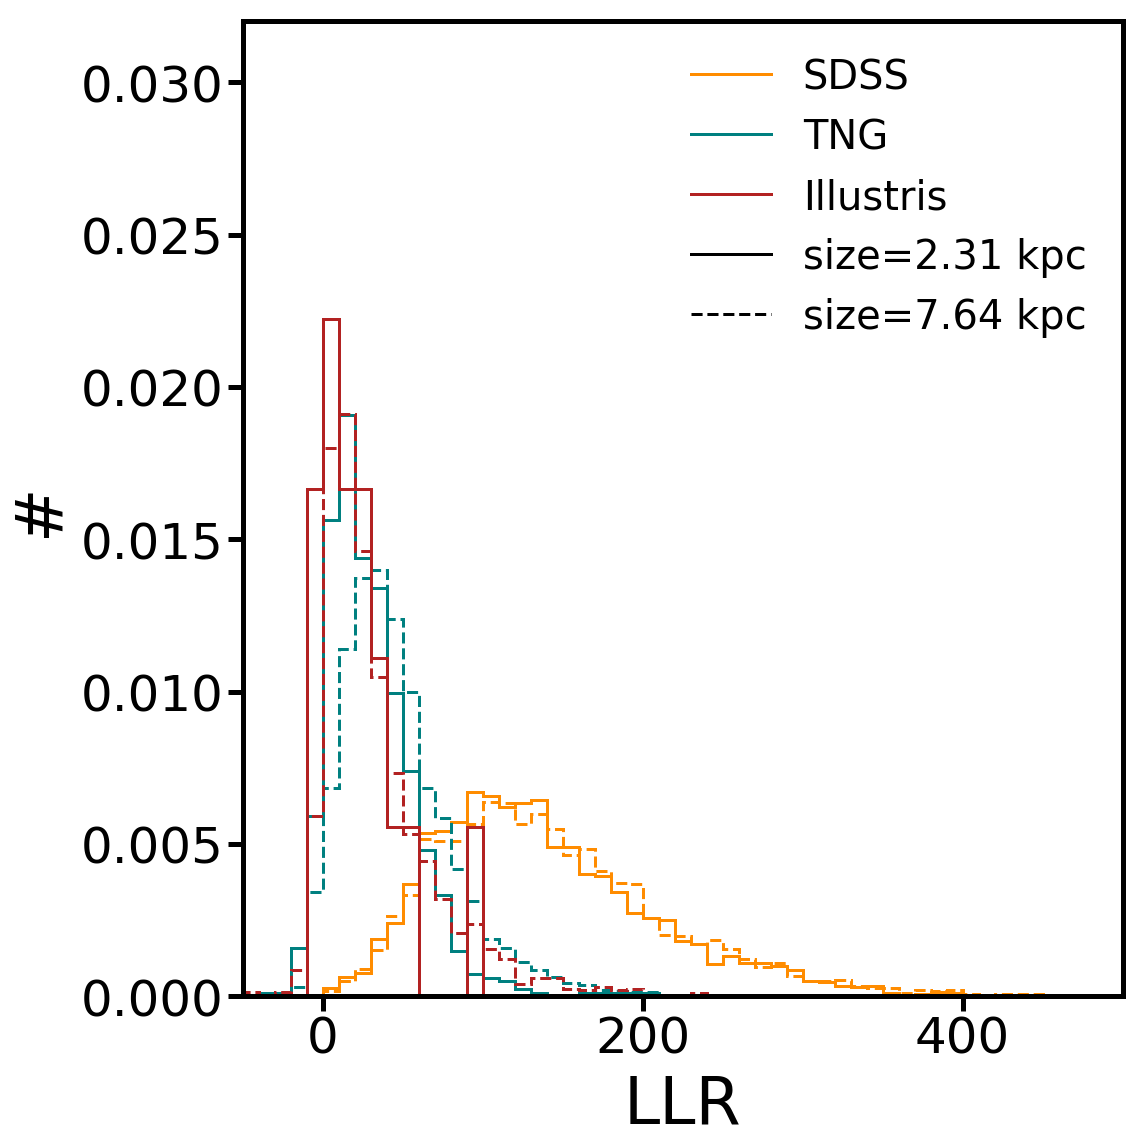

In [246]:
magbins = [low, med, up]
linestyles = ['-','--','-.',':']
colors = ['darkorange','teal','firebrick']
labels = ['SDSS','TNG','Illustris']
dsets = [SDSS, TNG,Illustris]


for dset, (lab,col) in zip(dsets, zip(labels,colors)):
    for i, ls in zip(range(len(magbins)-1),linestyles):
        df = dset[(dset['sersic_rhalf'].apply(np.log10)>magbins[i]) & (dset['sersic_rhalf'].apply(np.log10)<magbins[i+1])]
        plt.hist(df['LLR'].values,histtype='step', density=True, color=col, linestyle=ls, lw=3, bins=np.arange(-50,500,10))
        
x = np.arange(100,100)+10000
plt.plot(x,x, color=colors[0], label='SDSS', lw=3)
plt.plot(x,x, color=colors[1], label='TNG', lw=3)
plt.plot(x,x, color=colors[2], label='Illustris', lw=3)

magwidth = magbins[1]-magbins[0]
meanmags = magbins[1:]-magwidth/2.

for m, ls in zip(meanmags, linestyles):
    plt.plot(x,x, color='black',lw=3,ls=ls, label='size={} kpc'.format(np.round(10**m,2)))
    
plt.xlim(-50,500)
plt.ylim(0,0.032)
plt.legend(frameon=False, fontsize=40)
plt.xlabel('LLR')
plt.ylabel('#')
plt.tight_layout()
plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/LLR_L_trends/size.png')

## sersic index

In [248]:
SDSS = SDSS.rename(columns={'n_bulge':'sersic_n'})

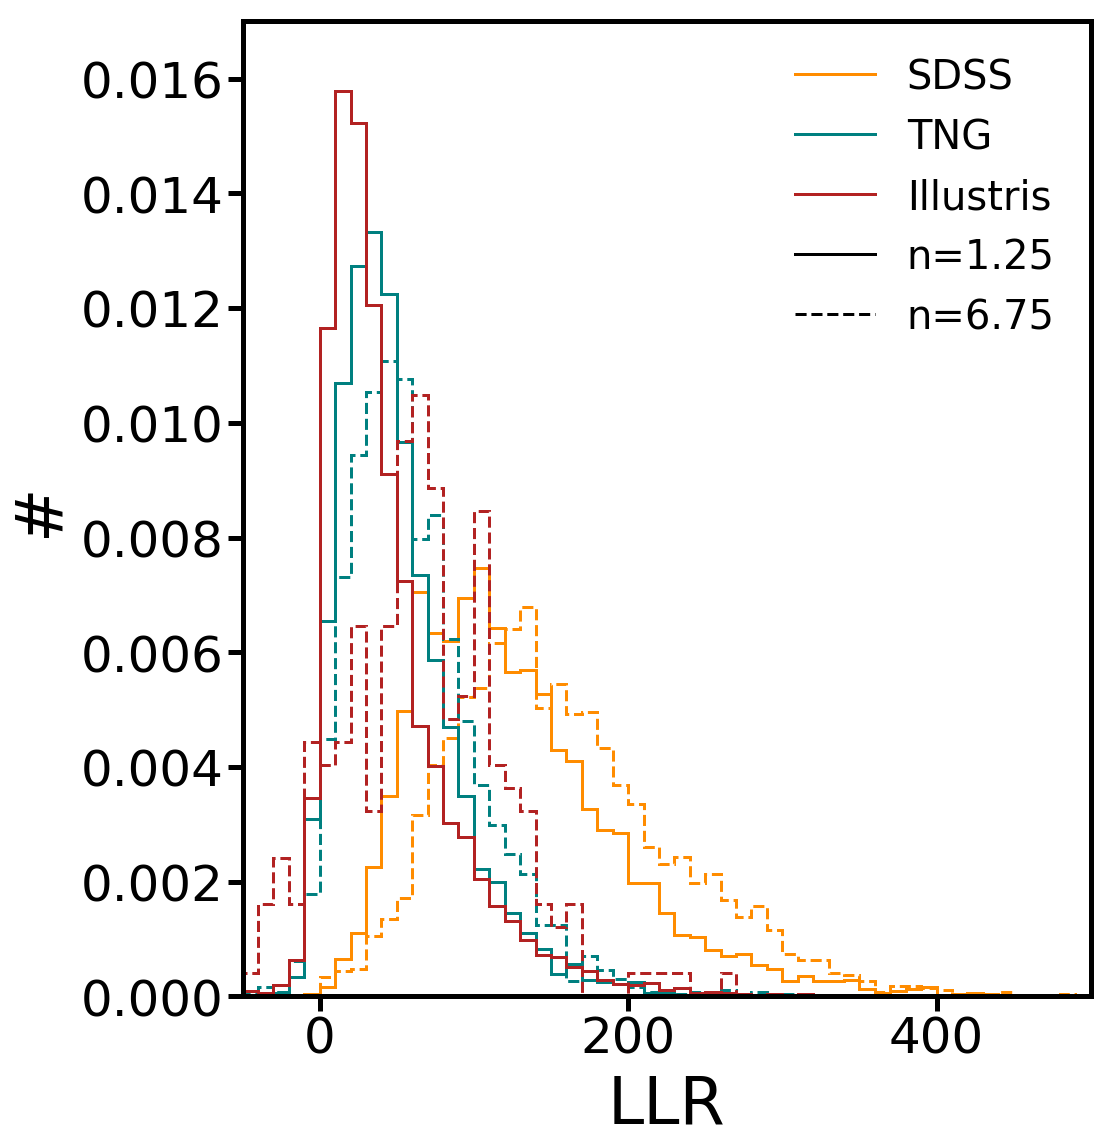

In [252]:
magbins = np.array([0, 2.5, 8])
linestyles = ['-','--','-.',':']
colors = ['darkorange','teal','firebrick']
labels = ['SDSS','TNG','Illustris']
dsets = [SDSS, TNG,Illustris]


for dset, (lab,col) in zip(dsets, zip(labels,colors)):
    for i, ls in zip(range(len(magbins)-1),linestyles):
        df = dset[(dset['sersic_n']>magbins[i]) & (dset['sersic_n']<magbins[i+1])]
        plt.hist(df['LLR'].values,histtype='step', density=True, color=col, linestyle=ls, lw=3, bins=np.arange(-50,500,10))
        
x = np.arange(100,100)+10000
plt.plot(x,x, color=colors[0], label='SDSS', lw=3)
plt.plot(x,x, color=colors[1], label='TNG', lw=3)
plt.plot(x,x, color=colors[2], label='Illustris', lw=3)

magwidth = magbins[1]-magbins[0]
meanmags = magbins[1:]-magwidth/2.

for m, ls in zip(meanmags, linestyles):
    plt.plot(x,x, color='black',lw=3,ls=ls, label='n={}'.format(np.round(m,2)))
    
plt.xlim(-50,500)
plt.ylim(0,0.017)
plt.legend(frameon=False, fontsize=40)
plt.xlabel('LLR')
plt.ylabel('#')
plt.tight_layout()
plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/LLR_L_trends/sersic.png')